In [1]:
import pandas as pd

### Clean the data

In [2]:
input_dataset = pd.read_csv("Customer data for churn.csv")

### i found this is a monthly data, but same client same product same month have multiple value. see below
input_dataset[(input_dataset['Customer_Name_Redacted'] == 'Customer 1332') & (input_dataset['KPMG_Sales_Date']=='2021-12-01')].sort_values(by=['Product_Name_Redacted'])

### therefore, we need to aggregate/sum up the records by month.
grouped_df = input_dataset.groupby(['KPMG_Sales_Date', 'Customer_Name_Redacted', 'Product_Category_Redacted', 'Product_Name_Redacted']).agg({'KPMG_ARR_Reported_AUD': 'sum'}).reset_index()


In [10]:
### now the main focus is grouped_df
df = grouped_df.copy()

### convert the data to monthly data
df['KPMG_Sales_Date'] = pd.to_datetime(df['KPMG_Sales_Date'])
df['year'] = df['KPMG_Sales_Date'].dt.year
df['month'] = df['KPMG_Sales_Date'].dt.month

### remove data if the date is after 2021-12-01
df = df[df['KPMG_Sales_Date'] < '2023-07-01']
df = df[df['KPMG_ARR_Reported_AUD']>0]
df=df[df['Product_Name_Redacted'] != 'Product Name 22']

In [4]:
grouped_df.head()

,KPMG_Sales_Date,Customer_Name_Redacted,Product_Category_Redacted,Product_Name_Redacted,KPMG_ARR_Reported_AUD
0,2016-12-01,Customer 1285,Product Category 4,Product Name 11,0.00
1,2016-12-01,Customer 1427,Product Category 6,Product Name 24,35964.00
2,2016-12-01,Customer 1564,Product Category 6,Product Name 24,3196.80
3,2016-12-01,Customer 1573,Product Category 4,Product Name 11,7600.08
4,2016-12-01,Customer 1632,Product Category 6,Product Name 24,21600.00


### some EDA

In [6]:
# how long is the total years with us? 2021-2018 = 3 years
temp=df.groupby(['Customer_Name_Redacted']).agg({'KPMG_Sales_Date': ['min', 'max']}).reset_index()
temp['engagement_mth'] = round((temp['KPMG_Sales_Date']['max'] - temp['KPMG_Sales_Date']['min']).dt.days/30,0)


### total dollar amount during the engagement 
temp2 = df.groupby(['Customer_Name_Redacted']).agg({'KPMG_ARR_Reported_AUD': 'sum'}).reset_index()
temp = pd.merge(temp, temp2, on='Customer_Name_Redacted', how='left')

### how many product category in total?
temp3 = df.groupby(['Customer_Name_Redacted']).agg({'Product_Category_Redacted': 'nunique'}).reset_index()
temp3.rename(columns={'Product_Category_Redacted': 'Product_Category_Count'}, inplace=True)

### how many products in total?
temp4 = df.groupby(['Customer_Name_Redacted']).agg({'Product_Name_Redacted': 'nunique'}).reset_index()
temp4.rename(columns={'Product_Name_Redacted': 'Product_Name_Count'}, inplace=True)

### merge all the above together
temp = pd.merge(temp, temp3, on='Customer_Name_Redacted', how='left')
temp = pd.merge(temp, temp4, on='Customer_Name_Redacted', how='left')

temp = temp.loc[:, ~temp.columns.duplicated()] 

### clean column names removing special characters
temp.columns = temp.columns.map(''.join)

## create a new column, if the max date is more than '2023-01-01' then 1 otherwise 0
temp['future'] = temp['KPMG_Sales_Datemax'].dt.year.apply(lambda x: 1 if x > 2023 else 0)
 
### whatt is the percentage of client with future flag?
temp['future'].value_counts(normalize=True)  ### looks like it is 13.72% have projected income, regardless of they churn or not.


# calculate the "churn" column based on whether the date is before today's date
import datetime

today_date = datetime.date(2023, 6, 1)
temp['churn'] = temp['KPMG_Sales_Datemax'].apply(lambda x: 1 if x.date() < today_date else 0)

### remove if any clients have zero engagement with 0 dollars

rows_to_remove = temp[(temp['KPMG_Sales_Datemax'] == temp['KPMG_Sales_Datemin']) & (temp['KPMG_ARR_Reported_AUD']<=0)].index

# remove the rows from the DataFrame
temp = temp.drop(rows_to_remove)
temp = temp.loc[:, ~temp.columns.duplicated()] 

######################################################################################################################################################

# ### top and bottom 25% clients who have the longest engagement with us

# # calculate the quartiles of engagement duration
# quartiles = temp['engagement_mth'].quantile([0.25, 0.75])

# # # find the threshold values for top and bottom quartiles
# top_threshold = quartiles.loc[0.75]
# bottom_threshold = quartiles.loc[0.25]

# # # find the clients in the top and bottom quartiles
# top_clients=temp[temp['engagement_mth'] >= top_threshold]['Customer_Name_Redacted']

# bottom_clients = temp[temp['engagement_mth'] <= bottom_threshold]['Customer_Name_Redacted']

# # # join back with the table df to see what products they buy?
# top_clients_df = pd.merge(df, top_clients, on='Customer_Name_Redacted', how='inner')
# bottom_clients_df = pd.merge(df, bottom_clients, on='Customer_Name_Redacted', how='inner')

# ### for top clients, what is the top 5 product category they buy?
# print(top_clients_df.groupby('Product_Category_Redacted')['KPMG_ARR_Reported_AUD'].sum().sort_values(ascending=False).head(5))
# print(top_clients_df.groupby('Product_Name_Redacted')['KPMG_ARR_Reported_AUD'].sum().sort_values(ascending=False).head(5))

# ### for bottom clients, what is the top 5 product category they buy?
# print(bottom_clients_df.groupby('Product_Category_Redacted')['KPMG_ARR_Reported_AUD'].sum().sort_values(ascending=False).head(5))
# print(bottom_clients_df.groupby('Product_Name_Redacted')['KPMG_ARR_Reported_AUD'].sum().sort_values(ascending=False).head(5))


C:\Users\mkong2\AppData\Local\Temp\ipykernel_13044\829464961.py:7: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  temp = pd.merge(temp, temp2, on='Customer_Name_Redacted', how='left')


In [12]:
### export temp
temp.to_csv('customer_level.csv', index=False)

In [236]:

         
### export df
df.to_csv('monthly_data.csv', index=False)

### RFM


version 2 

In [237]:
import datetime as dt
today_date1 = dt.datetime(2023, 6, 1)

df1 = df.copy()

cltv = df1.groupby('Customer_Name_Redacted').agg({
    'KPMG_Sales_Date': [
        lambda x: (x.max() - x.min()).days,  # recency
        lambda x: (today_date1 - x.min()).days  # T
    ],
    'Product_Name_Redacted': lambda x: x.count(),  # frequency
    'KPMG_ARR_Reported_AUD': lambda x: x.sum()  # monetary
})

##### Tidy up columns
cltv.columns = cltv.columns.droplevel(0)
cltv.columns = ['recency', 'T', 'frequency', 'monetary']

### filter out 
cltv = cltv[cltv['monetary'] > 0]
cltv['monetary'] = cltv['monetary'] / cltv['frequency']   ### avg spending

# transforming days to months
cltv['recency'] = cltv['recency'] / 30
cltv['T'] = cltv['T'] / 30

## filter out
cltv = cltv[(cltv['frequency'] > 1)]



In [238]:
##### top clients with most purchase
#####build the model
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv['frequency'], cltv['recency'], cltv['T'])

top_customer_most_purchase = bgf.conditional_expected_number_of_purchases_up_to_time(12, # months
                                                        cltv['frequency'],
                                                        cltv['recency'],
                                                        cltv['T']).sort_values(ascending=False)


top_customer_most_purchase = pd.DataFrame(top_customer_most_purchase).reset_index()
top_customer_most_purchase.columns=['Customer_Name_Redacted','Score']

## merge this table with customer table 
 
top_customer_most_purchase = pd.merge(top_customer_most_purchase, temp, on='Customer_Name_Redacted', how='left')
# export this dataset
top_customer_most_purchase.to_csv('top_customer_most_purchase.csv', index=False)

In [239]:
##### valuable clients

from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv['frequency'], cltv['monetary'])

####
top_customer_most_valuable =ggf.conditional_expected_average_profit(cltv['frequency'],
                               cltv['monetary']).sort_values(ascending=False)

top_customer_most_valuable = pd.DataFrame(top_customer_most_valuable).reset_index()
top_customer_most_valuable.columns=['Customer_Name_Redacted','Score']
## merge this table with customer table 
 
top_customer_most_valuable = pd.merge(top_customer_most_valuable, temp, on='Customer_Name_Redacted', how='left')
# export this dataset
top_customer_most_valuable.to_csv('top_customer_most_valuable.csv', index=False)

In [241]:
# The customers' lifetime values expected to in the next 3 months
cltv['cltv_pred_FY24'] = ggf.customer_lifetime_value(bgf,
                                   cltv['frequency'],
                                   cltv['recency'],
                                   cltv['T'],
                                   cltv['monetary'],
                                   time= 12,  # 6 months

                                   freq="M",  
# frequency information of T. In this case we set week by using 'W'
                                   discount_rate=0.01) 

cltv = pd.DataFrame(cltv).reset_index()
cltv['segment'] = pd.qcut(cltv['cltv_pred_FY24'],3,['Low','Medium','High'])
cltv.to_csv('cltv.csv', index=False)

c:\Users\mkong2\AppData\Local\Programs\Python\Python39\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

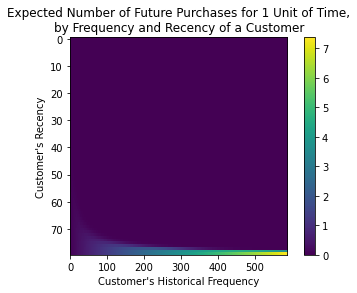

In [242]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

In [24]:
df[df['Customer_Name_Redacted']=='Customer 2761' ]['KPMG_ARR_Reported_AUD'].sum()


5157015.311999999

In [21]:
df[df['Product_Name_Redacted']=='Product Name 20' ]

,KPMG_Sales_Date,Customer_Name_Redacted,Product_Category_Redacted,Product_Name_Redacted,KPMG_ARR_Reported_AUD,year,month
2481,2017-11-01,Customer 1849,Product Category 8,Product Name 20,77229.953904,2017,11
2607,2017-11-01,Customer 2898,Product Category 8,Product Name 20,1693.554450,2017,11
2730,2017-11-01,Customer 3929,Product Category 8,Product Name 20,63330.397500,2017,11
2757,2017-11-01,Customer 4233,Product Category 8,Product Name 20,46603.886004,2017,11
2974,2017-12-01,Customer 1849,Product Category 8,Product Name 20,77229.953904,2017,12
...,...,...,...,...,...,...,...
124378,2021-04-01,Customer 2427,Product Category 8,Product Name 20,9999.960000,2021,4
127441,2021-04-01,Customer 4335,Product Category 8,Product Name 20,11244.000000,2021,4
128315,2021-04-01,Customer 5,Product Category 8,Product Name 20,20340.000000,2021,4
131337,2021-05-01,Customer 2427,Product Category 8,Product Name 20,10000.440000,2021,5


In [ ]:
df.